In [1]:
import torch
from torch import nn

In [2]:
import importlib

import MyModels
importlib.reload(MyModels)
from MyModels import ImageCNNv1, ImageCNNv2, ImageCNNv3, ImageCNNv4

import MyData
importlib.reload(MyData)
from MyData import load_CelebA

import MyTrainer
importlib.reload(MyTrainer)
from MyTrainer import Trainer

In [41]:
train_dataset, valid_dataset = load_CelebA(train=5000, valid=5000, test=False, random_seed=444, target_attr=18)
print(len(train_dataset), len(valid_dataset))

5000 5000


In [42]:
from torch.utils.data import DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=4)

model = ImageCNNv4(3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
loss_fn = nn.BCELoss()
trainer = Trainer(model, optimizer, loss_fn, train_loader, valid_loader)

In [43]:
train_loss_log, train_acc_log, valid_loss_log, valid_acc_log = trainer.train(epochs=10, scheduler=scheduler, log=True, device=device)

Epoch 1 acc: 0.5736 val_acc: 0.714
Epoch 2 acc: 0.7174 val_acc: 0.623
Epoch 3 acc: 0.7702 val_acc: 0.610
Epoch 4 acc: 0.8018 val_acc: 0.823
Epoch 5 acc: 0.8342 val_acc: 0.806
Epoch 6 acc: 0.8524 val_acc: 0.843
Epoch 7 acc: 0.8630 val_acc: 0.840
Epoch 8 acc: 0.8770 val_acc: 0.824
Epoch 9 acc: 0.8734 val_acc: 0.826
Epoch 10 acc: 0.8806 val_acc: 0.876


In [44]:
for i in range(len(train_loss_log)):
    print(f'Epoch {i+1:2d} loss: {train_loss_log[i]:13.10}, val_loss: {valid_loss_log[i]:13.10}')

Epoch  1 loss:  0.6785492645, val_loss:  0.6018281472
Epoch  2 loss:  0.5790664178, val_loss:  0.6580726916
Epoch  3 loss:  0.5115411392, val_loss:  0.7374503395
Epoch  4 loss:  0.4555518833, val_loss:  0.3825618687
Epoch  5 loss:  0.4012193006, val_loss:  0.4187509148
Epoch  6 loss:   0.362224089, val_loss:  0.3493561891
Epoch  7 loss:  0.3330007121, val_loss:  0.3539438227
Epoch  8 loss:  0.3135101743, val_loss:  0.3837385752
Epoch  9 loss:  0.3041127821, val_loss:  0.4417093102
Epoch 10 loss:   0.296871048, val_loss:  0.2800316608


In [45]:
for i in range(len(train_acc_log)):
    print(f'Epoch {i+1:2d} acc: {train_acc_log[i]:10.7f}, val_acc: {valid_acc_log[i]:10.7f}')

Epoch  1 acc:  0.5736000, val_acc:  0.7144000
Epoch  2 acc:  0.7174000, val_acc:  0.6234000
Epoch  3 acc:  0.7702000, val_acc:  0.6096000
Epoch  4 acc:  0.8018000, val_acc:  0.8226000
Epoch  5 acc:  0.8342000, val_acc:  0.8062000
Epoch  6 acc:  0.8524000, val_acc:  0.8434000
Epoch  7 acc:  0.8630000, val_acc:  0.8404000
Epoch  8 acc:  0.8770000, val_acc:  0.8242000
Epoch  9 acc:  0.8734000, val_acc:  0.8258000
Epoch 10 acc:  0.8806000, val_acc:  0.8758000


In [68]:
wrong = []
right = []

model.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(valid_dataset):
        if i < 100:
            continue
        x = x.unsqueeze(0).to(device)
        y = y.to(device)

        pred = model(x).squeeze(1)
        if (pred>=0.5) == y:
            right.append((i, pred.item()))
        else:
            wrong.append((i, pred.item()))

        if len(right) >= 18 and len(wrong) >= 18:
            break

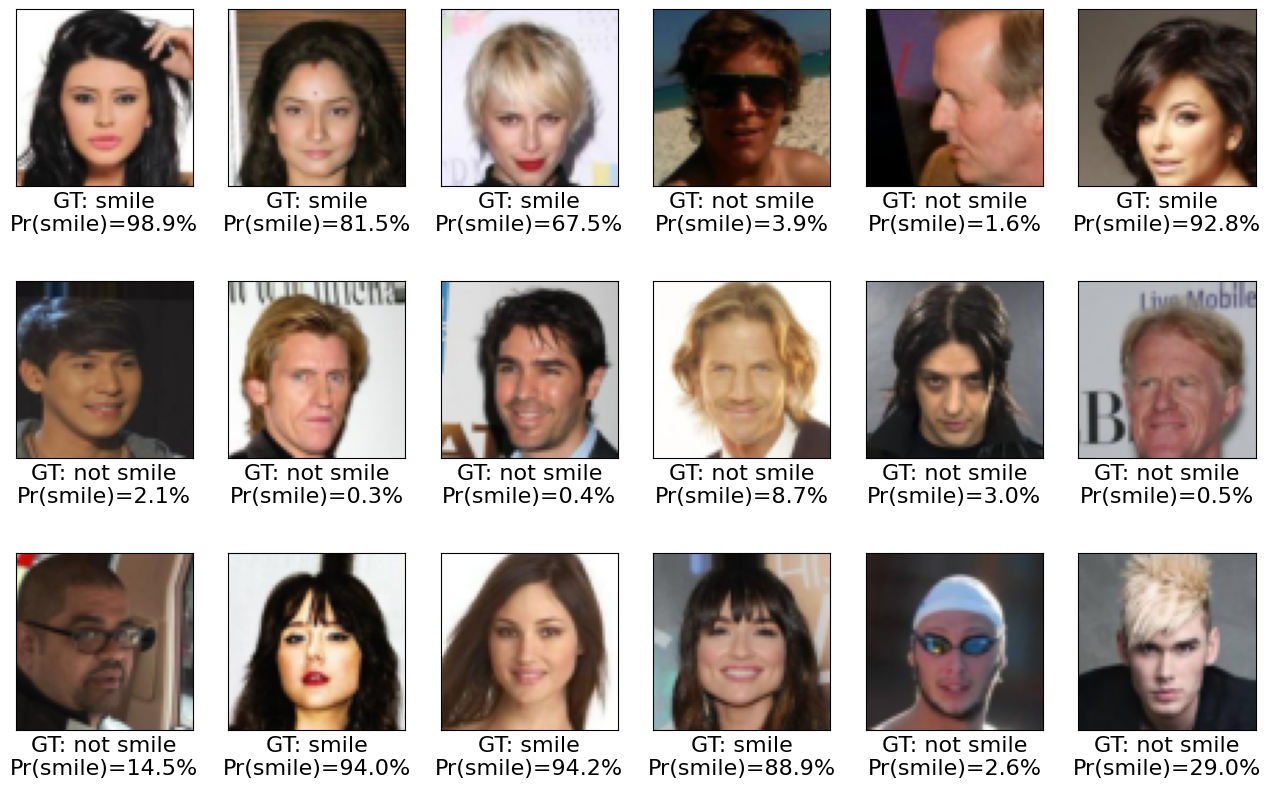

In [69]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 10))
for i in range(18):
    j, pred = right[i]
    img, lbl = valid_dataset[j]

    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

    label = 'smile' if lbl==1 else 'not smile'
    ax.text(0.5, -0.15, f'GT: {label:s}\nPr(smile)={pred*100:.1f}%',size=16,
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()

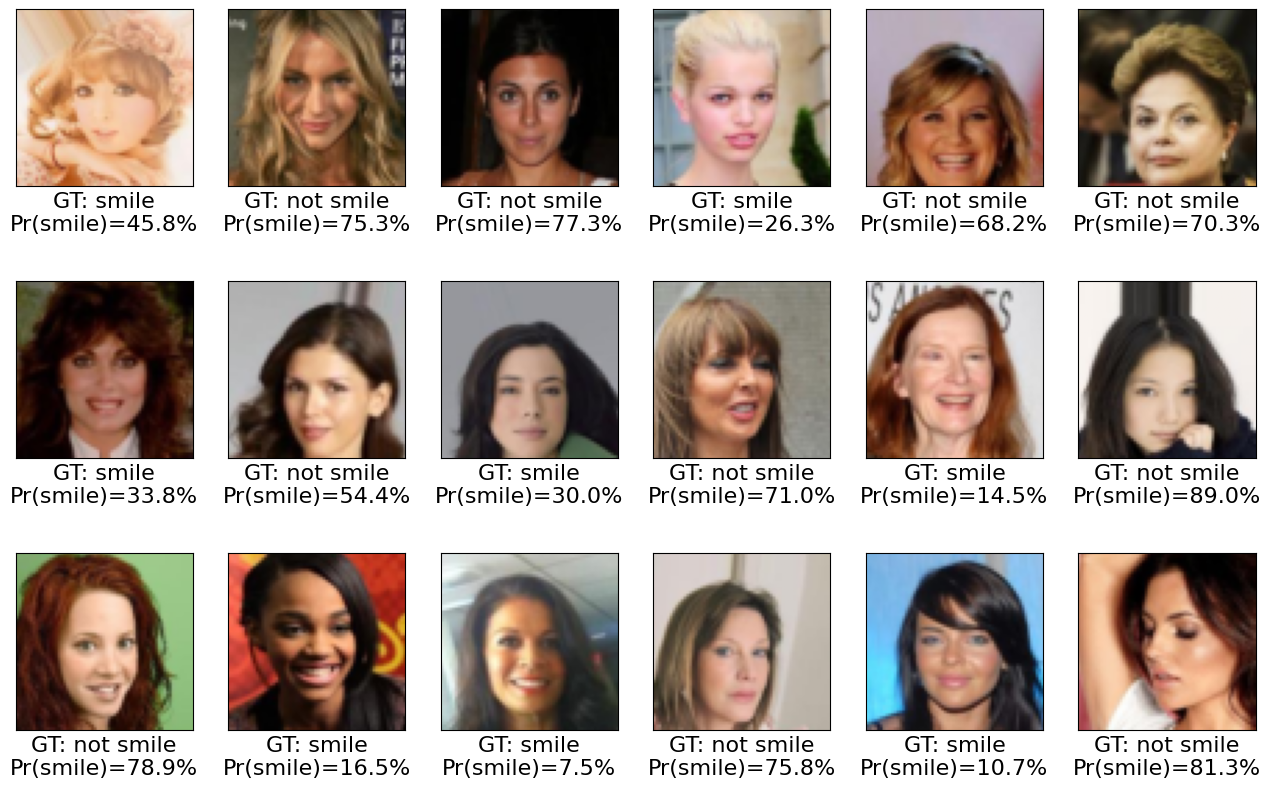

In [70]:
fig = plt.figure(figsize=(16, 10))
for i in range(18):
    j, pred = wrong[i]
    img, lbl = valid_dataset[j]

    ax = fig.add_subplot(3, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.permute(1, 2, 0))

    label = 'smile' if lbl==1 else 'not smile'
    ax.text(0.5, -0.15, f'GT: {label:s}\nPr(smile)={pred*100:.1f}%',size=16,
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes)

plt.show()